Use pandas to explore Github's repository statistics api`...`

> [The Repository Statistics API allows you to fetch the data that GitHub uses for visualizing different types of repository activity.](https://developer.github.com/v3/repos/statistics/)

In [1]:
%matplotlib inline
from toolz.curried import *; from matplotlib.pyplot import *; from pandas import *
import seaborn as sns; s, df = Series, DataFrame
o = __name__ == '__main__'

# Analyzing Github Repository Statistics with Pandas

## Requests to the Github Statistics API.

The first _request_ computes the repo statistics returning a `202` status code.  With sufficient delay the next _request_ will return a `200` code that becomes our dataframe.

In [2]:
url = 'https://api.github.com/repos/' + 'nteract/nteract'
def _request_(response):
    """Access a github api that returns a 202 status_code."""
    if type(response) is str: response = __import__('requests').get(response)
    return (__import__('time').sleep(1) or _request_(response) if response.status_code is 202 else DataFrame(response.json()))
_get_ = memoize(lambda x: _request_(x))

## Commit Activity

> [Get the last year of commit activity data](https://developer.github.com/v3/repos/statistics/#get-the-last-year-of-commit-activity-data)

In [3]:
if o:
    df = _get_(url+'/stats/commit_activity')
    df.week = df.week.pipe(to_datetime, unit='s')

    ts = df.days.apply(compose(Series, dict, enumerate))
    ts.columns = to_timedelta(ts.columns.map("{} days".format))
    ts = ts.set_index(df.week).stack().reset_index().pipe(
        lambda df: DataFrame(df[0].values, df.week.add(df.level_1))).rename(columns={0: 'commits'})
    ts = ts.set_index(MultiIndex.from_arrays([
        to_datetime(sum(df.week.apply(lambda x: [x]*7).tolist(), [])),
        Index(ts.index.dayofweek, name='dayofweek')])).unstack(-1)
    ts.head()

## Code Frequency

> [Returns a weekly aggregate of the number of additions and deletions pushed to a repository.](https://developer.github.com/v3/repos/statistics/#get-the-number-of-additions-and-deletions-per-week)

In [4]:
if o:
    code_freq = _get_(url+'/stats/code_frequency')
    code_freq.columns = ['time', *'+-']
    code_freq = code_freq.pipe(
        lambda df: setattr(df, 'time', df.time.pipe(to_datetime, unit='s')) or df).set_index('time')
    code_freq.tail()

## The Join

In [5]:
if o:
    ts = concat([concat({'freq': code_freq}, axis=1), ts], axis=1)
    ts.dropna().sample(3)

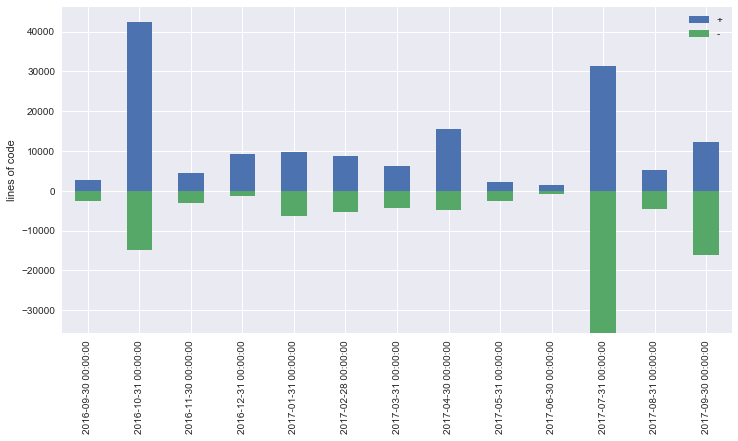

In [6]:
if o:
    ts.dropna().freq.groupby(TimeGrouper('1M')).sum().plot.bar(stacked=True, figsize=(12, 6))
    ylabel('lines of code')